In [1]:
import cv2
import numpy as np
import time
import math
import pandas
from datetime import timedelta
import matplotlib.pyplot as plt

fps = np.array([1, 3, 5, 10, 15, 20])
fps2 = np.array([3, 15])
fps3 = np.array([3, 15, 20])

## Node data

### 1 node

In [2]:
''' RGB '''
# rgb unencoded 1024
rgb_bw = np.array([18, 42, 66, 150, 195, 270])
rgb_cpu_os = np.array([4, 6.3, 9.3, 17.8, 26.5, 38])
rgb_cpu_rt = np.array([0.3, 0.4, 0.6, 1.2, 1.8, 2.6])

# rgb encoded 1024
rgbe_bw = np.array([2.3, 5.6, 9.75, 19.3, 24.5, 41.5])
rgbe_cpu_os = np.array([2.5, 3.5, 6.5, 12.5, 14.5, 25.5])
rgbe_cpu_rt = np.array([0.29, 0.4, 0.68, 1.3, 1.9, 2.8])

# rgb unencoded 2048
rgb2_bw = np.array([169, 750, 830])
rgb2_cpu_os = np.array([15, 73, 87])
rgb2_cpu_rt = np.array([0.6, 2.8, 4])

''' LR '''
# lr unencoded 800p
lr_bw = np.array([31, 55, 110, 185, 260, 345])
lr_cpu_os = np.array([5.9, 8, 12.5, 24.5, 37, 49])
lr_cpu_rt = np.array([0.4, 0.55, 0.9, 1.9, 2.5, 3.5])

# lr encoded 800p
lre_bw = np.array([18, 71])
lre_cpu_os = np.array([5.8, 25])
lre_cpu_rt = np.array([1, 4.8])

''' Depth '''
# Depth 800p res SubPixel = T, Encoding = F
depth_bw = np.array([31, 52.5, 80, 196, 251, 326])
depth_cpu_os = np.array([6, 8.5, 12.8, 25.1, 37.9, 52.5])
depth_cpu_rt = np.array([0.5, 0.8, 1.3, 2.6, 3.8, 6.5])


### 2 nodes

In [3]:
''' RGB+LR '''
# RGB uenc, LR
rgblr_bw = np.array([49.5, 80, 160, 310, 440, 560])
rgblr_cpu_os = np.array([8, 13.5, 21.5, 43, 65, 96])
rgblr_cpu_rt = np.array([0.6, 1.05, 1.7, 3.3, 5.6, 7.4])

# RGB enc, LR
rgbelr_bw = np.array([35, 60, 79, 190, 274, 380])
rgbelr_cpu_os = np.array([6.5, 10.5, 17.5, 35.5, 52.5, 75.5])
rgbelr_cpu_rt = np.array([0.6, 1.05, 1.75, 3.45, 5.2, 10])

''' RGB+Depth '''
# RGB uenc, Depth SubPixel=T
rgbdepth_bw = np.array([49.5, 100, 160, 300, 440, 540])
rgbdepth_cpu_os = np.array([8, 13.6, 21.5, 44, 68.5, 99.94])
rgbdepth_cpu_rt = np.array([0.7, 1.75, 2.9, 5.65, 9.1, 14])

# RGB enc, Depth SubPixel=T
rgbedepth_bw = np.array([35, 55, 115, 195, 286, 365])
rgbedepth_cpu_os = np.array([7.5, 11.5, 18, 35.5, 56.5, 83.5])
rgbedepth_cpu_rt = np.array([0.75, 1.8, 3, 5.9, 9.3, 17])

''' LR+Depth '''
# LR uenc, Depth SubPixel=T
lrdepth_bw = np.array([62, 115, 150, 320, 480, 644])
lrdepth_cpu_os = np.array([8.5, 12.5, 20, 39, 58.5, 79.5])
lrdepth_cpu_rt = np.array([0.7, 0.99, 1.65, 3.2, 4.8, 7.5])

lredepth_bw = np.array([37, 63, 115, 225, 315, 400])
lredepth_cpu_os = np.array([7.7, 9.5, 15.3, 30.6, 45.5, 63.75])
lredepth_cpu_rt = np.array([0.99, 1.5, 2.4, 4.7, 7.03, 9.5])

### 3 nodes

In [4]:
''' RGB + LR + Depth '''
rgblrdepth_bw = np.array([85, 155, 235, 435, 645, 660])
rgblrdepth_cpu_os = np.array([12.5, 17.5, 29, 57, 94.5, 99.99])
rgblrdepth_cpu_rt = np.array([0.75, 1.95, 3.2, 6.4, 10, 10.5])

''' RGB enc + LR + Depth '''
rgbelrdepth_bw = np.array([51, 115, 195, 353, 515, 565])
rgbelrdepth_cpu_os = np.array([10.5, 15.5, 25.5, 50, 79, 99.99])
rgbelrdepth_cpu_rt = np.array([0.8, 2, 3.3, 6.5, 10.5, 13])

''' RGB enc + LR enc + Depth '''
rgbelredepth_bw = np.array([39, 65, 115, 235, 315, 435])
rgbelredepth_cpu_os = np.array([8.5, 12.3, 20.5, 40, 62.5, 94.5])
rgbelredepth_cpu_rt = np.array([1.65, 2.5, 4.1, 8, 11.8, 21])

# Predictions

In [5]:
def get_poly(x, y):
    P = np.polyfit(x,y,1)
    return P

def predict(poly, var):
    equ = np.poly1d(poly)
    prediction = equ(var)
    return prediction

In [67]:
nodes = [rgb_cpu_rt, rgbe_cpu_rt, rgb2_cpu_rt, lr_cpu_rt, lre_cpu_rt, depth_cpu_rt]
nodes_pred = [[0.12, 0.05], [0.13, 0.04], [0.2, -0.03], [0.17, 0.14], [0.32, 0.05], [0.31, -0.14]]
x_axis = [fps, fps, fps3, fps, fps2, fps]

nodes_2 = [rgblr_cpu_rt, rgbelr_cpu_rt, rgbdepth_cpu_rt, rgbedepth_cpu_rt, lrdepth_cpu_rt, lredepth_cpu_rt]
'''
m2 = np.array([3.4, 4, 5.3, 10.6, 16.4, 22])
[0.01761371 0.65114303 2.19197552] [ 2.86073226  4.30392804  5.88803354 10.46477731 15.9222068  22.26032204]

This is based on 3 degree polynomial
m2_enc = np.array([ 2.87,  4.8, 4.93,  8.38, 17.4, 31.08])
[ 0.08609341 -0.38875667  4.17031117] [ 3.86764792  3.77888187  4.37886312  8.89208568 17.70997883 30.83254258]
m2_enc = np.array([3.9, 3.8, 4.4, 8.9, 17.7, 30.8])

This is based on 2 degree polynomial
m2_enc = np.array([0.9, 4.8, 6.5, 11.5, 17.4, 21.75])
[-0.01072457  1.29252315  0.20073695] [ 1.48253553  3.98178528  6.39523848 12.05351162 17.17555637 21.76137272]
m2_enc = np.array([1.48, 3.98, 6.4, 12.05, 17.18, 21.76])
'''
m2 = np.array([2.9, 4.3, 5.9, 10.5, 15.9, 22.3])
m2_enc = np.array([1.48, 3.98, 6.4, 12.05, 17.18, 21.76])
base = predict([-0.26, 1.78], fps)
mapping = [ [0, 3], [1, 3], [0, 5], [1, 5], [3, 5], [4, 5] ]

nodes_3 = [rgblrdepth_cpu_rt, rgbelrdepth_cpu_rt, rgbelredepth_cpu_rt]
mapping_3 = [[0, 3, 5], [1, 3, 5], [1, 4, 5]]


[-0.01072457  1.29252315  0.20073695] [ 1.48253553  3.98178528  6.39523848 12.05351162 17.17555637 21.76137272]


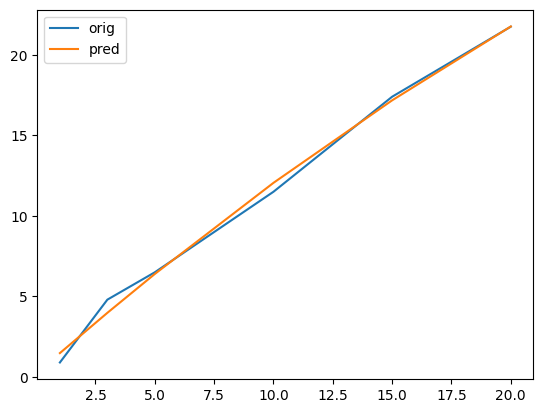

In [60]:
'''
find equations for common mono in lr and depth combos
'''
# val1 = np.array([3.4, 4, 5.3, 10.6, 16.4, 22])
# val1 = np.array([ 2.87,  4.8, 4.93,  8.38, 17.4, 31.08])
val1 = np.array([0.9, 4.8, 6.5, 11.5, 17.4, 21.75])

pol = np.polyfit(fps, val1, 2)
val2 = predict(pol, fps)
print(pol, val2)

plt.plot(fps, val1, fps, val2)
plt.legend(['orig', 'pred'])
plt.show()

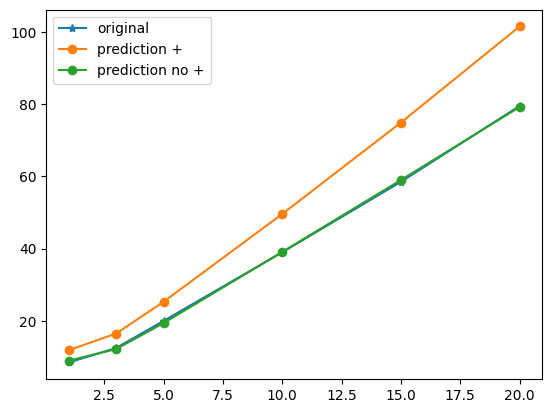

In [66]:
'''
plot lr+depth nodes with lr mono diff taken into account
'''

x = fps
opt = 4
opt_1 = mapping[opt][0]
opt_2 = mapping[opt][1]

orig = nodes_2[opt]

val1 = nodes[opt_1]
# val1 = predict(nodes_pred[opt_1], x)
# po = [2.06868343e-03, 3.11505054e-02, 4.62128227e-01, 4.07740632e+00]
# val1 = predict(po, x)

val2 = nodes[opt_2]
pred_wo = val1 + val2 - m2
pred_w = val1 + val2

plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
plt.legend(['original', 'prediction +2m', 'prediction no +2m'])
plt.show()


[-1.26  0.    0.56  0.96  1.16 -1.44]


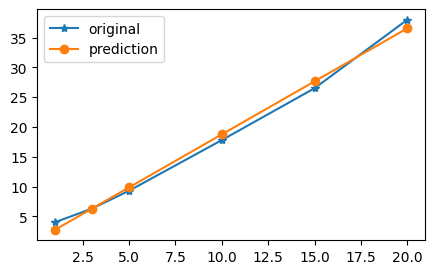

[-0.81  0.47 -0.25 -0.55  3.15 -2.15]


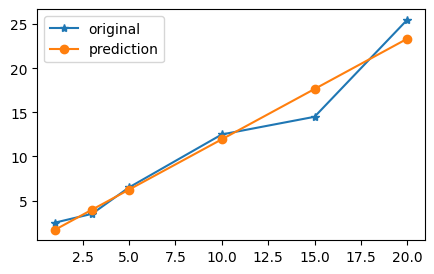

[ 1.34 -4.46  3.29]


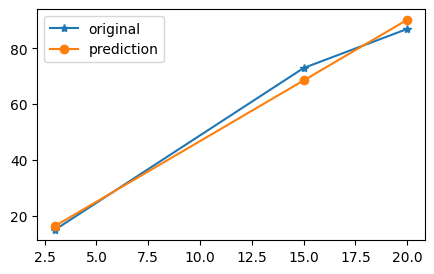

[-1.77  0.81  0.99  0.69 -0.11 -0.41]


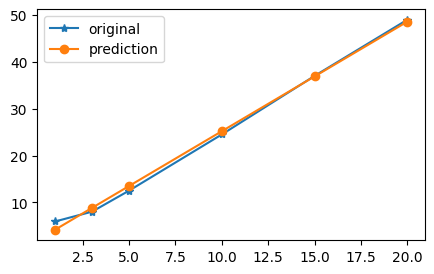

[8.8817842e-16 0.0000000e+00]


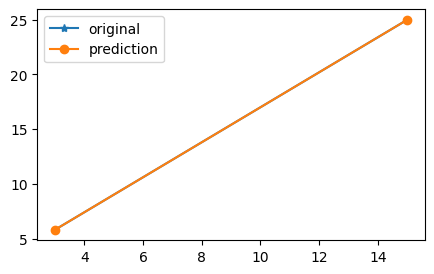

[-2.04  0.42  1.08  1.18  0.78 -1.42]


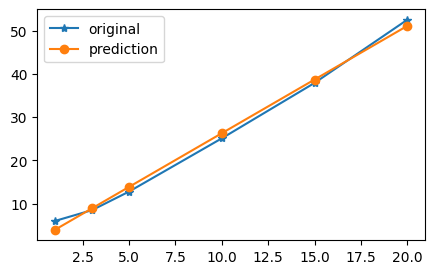

In [22]:
'''
1 node comparison to predicted values
'''

for opt in range(6):
    fig = plt.figure(figsize = (5, 3))
    x = x_axis[opt]

    orig = nodes[opt]
    pred = predict(nodes_pred[opt], x)
    diff = pred - orig
    print(diff)

    plt.plot(x, orig, '*-', x, pred, 'o-')
    plt.legend(['original', 'prediction'])
    plt.show()

In [63]:
'''get difference between original 2 nodes values and mathematical combination of 2 single nodes'''
x = fps

for opt in range(6):
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]

    orig = nodes_2[opt]
    if len(x_axis[opt_1])<4:
        val1 = predict(nodes_pred[opt_1], x)
    else:
        val1 = nodes[opt_1]
    if len(x_axis[opt_2])<4:
        val2 = predict(nodes_pred[opt_2], x)
    else:
        val2 = nodes[opt_2]
        
    if opt == 4:
        pred = val1 + val2 - m2
    elif opt == 5:
        pred = val1 + val2 - m2_enc
    else:
        pred = val1 + val2
    diff = pred - orig
    print(diff)
    
#     fig = plt.figure(figsize = (5, 3))
#     plt.plot(x, orig, '*-', x, pred, 'o-')
#     plt.legend(['original', 'prediction'])
#     plt.show()


[ 1.9  0.8  0.3 -0.7 -1.5 -9. ]
[ 1.9  1.   1.5  1.5 -1.  -1. ]
[ 2.    1.2   0.6  -1.1  -4.1  -9.44]
[ 1.   0.5  1.3  2.1 -4.1 -5.5]
[ 0.5 -0.3 -0.6  0.1  0.5 -0.3]
[-0.58  0.82  0.1  -0.55  0.22 -0.01]


[-0.25970803  1.78348337]


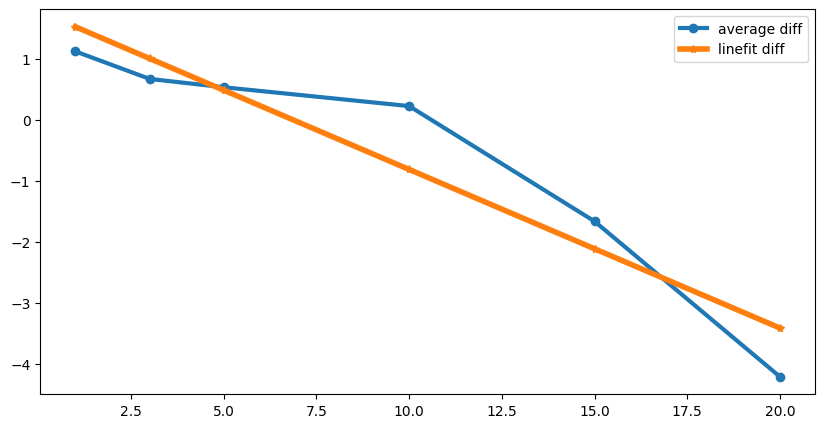

In [64]:
'''
getting line equation for differences between original 2 node values and mathematical combination of 1 nodes
(finding out the baseline)
'''
diffs_rt =[
    [ 0.1 -0.1 -0.2 -0.2 -1.3 -1.3],
    [ 0.09 -0.1  -0.17 -0.25 -0.8  -3.7 ],
    [ 0.1  -0.55 -1.   -1.85 -3.5  -4.9 ],
    [ 0.04 -0.6  -1.02 -2.   -3.6  -7.7 ],
    [0.2  0.36 0.55 1.3  1.5  2.5 ],
    [0.27152682 0.3        0.21806277 0.49225779 1.57       5.25279819]   
]



avg = []
for i in range(6):
    # get average of differences across a single fps
    vals = []
    for diff in diffs_rt:
        vals.append(diff[i])
    # get average of differences across a single fps
    avg.append(np.mean(vals))

coff = get_poly(fps, avg)
pred_avg = predict(coff, fps)
print(coff)

# plot the original average and predicted average
fig = plt.figure(figsize = (10, 5))

# for diff in diffs:
#     plt.plot(fps, diff, '*-')
plt.plot(fps, avg, 'o-', linewidth=3)
plt.plot(fps, pred_avg, '*-', linewidth=4)
plt.legend(['average diff', 'linefit diff'])
plt.show()

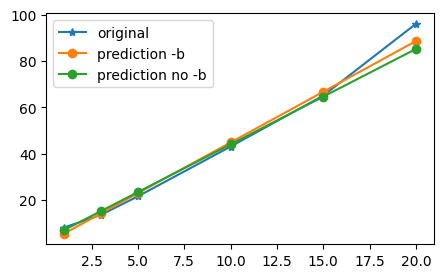

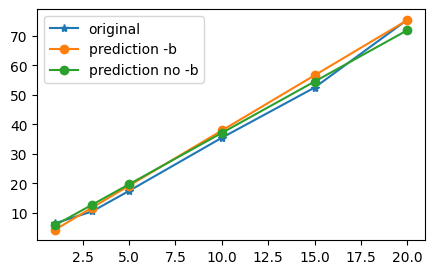

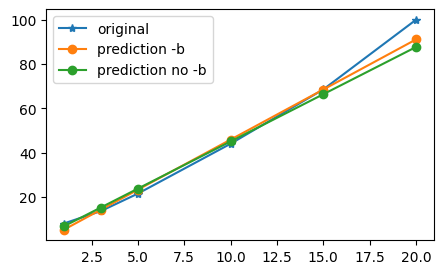

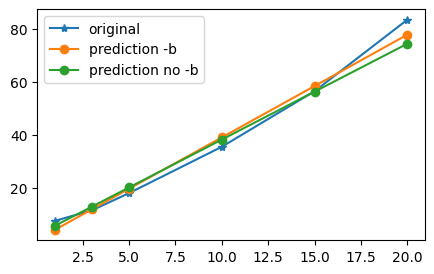

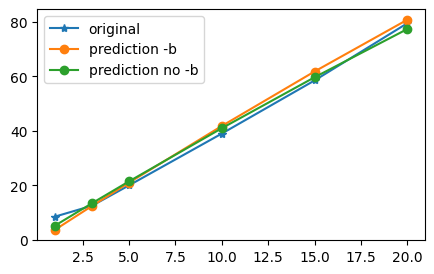

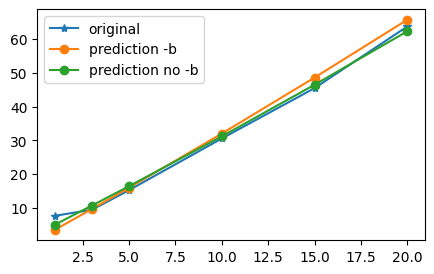

In [72]:
'''
2 nodes comparison to predicted values
'''
x = fps

for opt in range(6):
    fig = plt.figure(figsize = (5, 3))
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]

    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    
    if opt == 4:
        pred_wo = val1 + val2 - m2
        pred_w = val1 + val2 - base - m2
    elif opt == 5:
        pred_wo = val1 + val2 - m2_enc
        pred_w = val1 + val2 - base - m2_enc
    else:
        pred_wo = val1 + val2
        pred_w = val1 + val2 - base

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

[-1.67  6.53  8.23 13.23  8.73 36.24] [-4.71  4.53  7.27 14.87 12.97 43.08]


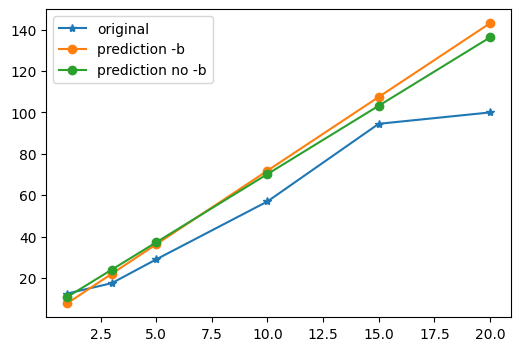

[-3.62  1.9   2.22  2.92 -1.68  0.73] [-6.66 -0.1   1.26  4.56  2.56  7.57]


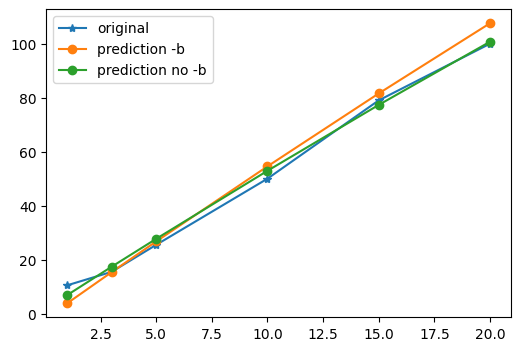

[-1.73  2.41  2.23  3.18  1.65 -8.83] [-4.77  0.41  1.27  4.82  5.89 -1.99]


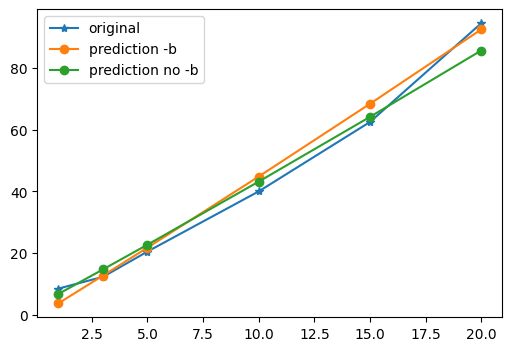

In [73]:
'''
3 nodes comparison to predicted values
'''
x = fps

for opt in range(3):
    fig = plt.figure(figsize = (6, 4))
    opt_1 = mapping_3[opt][0]
    opt_2 = mapping_3[opt][1]
    opt_3 = mapping_3[opt][2]


    orig = nodes_3[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    if opt == 1:
        val2 = val2 - m2
    if opt == 2:
        val2 = val2 - m2_enc

    val3 = predict(nodes_pred[opt_3], x)
    pred_wo = val1 + val2 + val3
    pred_w = val1 + (val2 - base) + (val3 - base)
    diff1 = pred_wo - orig
    diff2 = pred_w - orig
    print(diff1, diff2)

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

# when baseline is deducted, predicted values tend to fall below original more often (Fav:4, Neu:0,2, Det:1,3,5)

In [69]:
# without deduction, with deduction
